<a href="https://colab.research.google.com/github/pranavmicro7/Semantic-Segmenation-on-sub-dataset-of-Aerial-Image-Dataset/blob/master/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Downloading Dataset
!wget --no-check-certificate "https://onedrive.live.com/download?cid=42EC9A19F3DE58D8&resid=42EC9A19F3DE58D8%2176404&authkey=AL1hifFn8tw46Dk"
!unzip  '/content/download?cid=42EC9A19F3DE58D8&resid=42EC9A19F3DE58D8!76404&authkey=AL1hifFn8tw46Dk'

In [ ]:
import json
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from PIL import Image
!pip install keras-segmentation

In [ ]:
#Reading created annotation on JSON File 

path='/content/pond_json.json'
img_path='/content/AID/Pond/'

#os.mkdir('/content/annotated/')
#os.mkdir('/content/train/')

f=open(path)
data=json.load(f)

dict_img_name=[]

values_view=data.values()
value_iterator=iter(values_view)
first_value = next(value_iterator)

img_name=first_value['filename']
size=str(first_value['size'])

dict_img_name.append([img_name,size])

first_value = next(value_iterator)
while first_value:
 img_name=first_value['filename']
 size=str(first_value['size'])
 dict_img_name.append([img_name,size])
 
 first_value = next(value_iterator)

In [ ]:
#Extracting Coordinates of the annotation to create a polygon mask image

for i in range(len(dict_img_name)):
    
    img=plt.imread(img_path+dict_img_name[i][0])
    mask = img.copy()
    mask=(mask==88080808).astype(np.uint8)
    
    key=dict_img_name[i][0]+dict_img_name[i][1]
    for j in range(len(data[key]['regions'])) :
       x_c=data[key]['regions'][j]['shape_attributes']['all_points_x']
       y_c=data[key]['regions'][j]['shape_attributes']['all_points_y']
       
       coor=[]

       for k in range(len(x_c)):
           coor.append((x_c[k],y_c[k]))
       
        
       polygon = Polygon(coor)

       for x_p in range(img.shape[0]):
          for y_p in range(img.shape[1]):
            point=Point(y_p,x_p)
            if polygon.contains(point):
               mask[x_p,y_p,:]=img[x_p,y_p,:]
               
    plt.imsave('/content/annotated/'+dict_img_name[i][0],mask)
    plt.imsave('/content/train/'+dict_img_name[i][0],img)
    print(i)       

In [ ]:
#Preparing annotation folder to feed into network
os.mkdir('/content/annotated_imgs/')
k=1
for img_name in os.listdir('/content/annotated/'):
  print(k)
  k=k+1
  img= Image.open('/content/annotated/'+img_name)
  for i in range(np.shape(img)[0]):
    for j in  range(np.shape(img)[1]):
      if np.any(img.getpixel((i, j))) != 0: 
         img.putpixel( (i,j), (1,1,1))
  img.resize((416,608))       
  img.save('/content/annotated_imgs/'+img_name[:-3]+'png')       



**Model Used : VGG+U-Net**
</br>
</br>




In [ ]:

from keras_segmentation.models.unet import vgg_unet
epochs=10
n_classes = 2
model = vgg_unet(n_classes=n_classes ,  input_height=416, input_width=608  )

model.train( 
    train_images =  "/content/train",
    train_annotations = "/content/annotated_imgs",
    epochs=epochs
)


  6%|▌         | 12/196 [00:00<00:01, 116.35it/s]

Verifying training dataset


100%|██████████| 196/196 [00:01<00:00, 136.60it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 150s 293ms/step - loss: 0.2696 - accuracy: 0.9075
Epoch 2/10
512/512 [==============================] - 140s 273ms/step - loss: 0.2032 - accuracy: 0.9330
Epoch 3/10
512/512 [==============================] - 139s 272ms/step - loss: 0.1684 - accuracy: 0.9419
Epoch 4/10
512/512 [==============================] - 139s 271ms/step - loss: 0.1463 - accuracy: 0.9480
Epoch 5/10
512/512 [==============================] - 139s 271ms/step - loss: 0.1247 - accuracy: 0.9541
Epoch 6/10
512/512 [==============================] - 139s 271ms/step - loss: 0.1065 - accuracy: 0.9600
Epoch 7/10
512/512 [==============================] - 139s 271ms/step - loss: 0.0896 - accuracy: 0.9661
Epoch 8/10
512/512 [==============================] - 139s 271ms/step - loss: 0.0809 - accuracy: 0.9690
Epoch 9/10
512/512 [==============================] - 139s 271ms/step - loss: 0.0696 - accuracy: 0.9729
Epoch 10/10
512/512 [========================

In [ ]:
from keras_segmentation.predict import predict

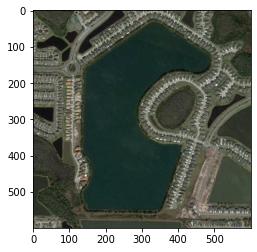

In [ ]:
img_p='/content/train/pond_100.jpg'
img=plt.imread(img_p)
plt.imshow(img)

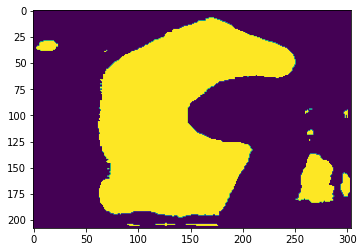

In [ ]:
out = model.predict_segmentation(
    inp=img_p,
    out_fname="/content/out.png"
)
plt.imshow(out)

<br>

**Custom Model :**

<br>
<br>


In [ ]:
from skimage.transform import resize
from skimage.io import imsave, imread

In [ ]:
#Data Processing
os.mkdir('/content/org_imgs/')
os.mkdir('/content/mask_imgs/')

img_h=256
img_w=256

k=1
for img_name in os.listdir('/content/annotated/'):
  print(k)
  k=k+1
  img= imread('/content/annotated/'+img_name)
  img=resize(img,(256,256))

  masked = np.zeros(( img_h, img_w), dtype=np.uint8)

  for i in range(np.shape(img)[0]):
    for j in  range(np.shape(img)[1]):
      if np.any(img[i,j,:]) != 0: 
         masked[i,j]=255

  org=imread('/content/train/'+img_name)  
  org=resize(org,(256,256))

  org.astype(dtype=np.uint8)
  masked.astype(dtype=np.uint8) 

  imsave('/content/mask_imgs/'+img_name[:-3]+'png',masked)   
  imsave('/content/org_imgs/'+img_name[:-3]+'png',org)         

In [ ]:
#Creating Dataset
num_imgs=len(os.listdir('/content/mask_imgs/'))
x_train = np.zeros((num_imgs, img_h, img_w, 3), dtype=np.uint8)
y_train = np.zeros((num_imgs, img_h, img_w, 1), dtype=np.bool)

for i, img_name in enumerate(os.listdir('/content/org_imgs')):
  print(i)
  org=imread('/content/org_imgs/'+img_name)
  mask=imread('/content/mask_imgs/'+img_name)

  mask = np.expand_dims(mask, axis=-1)

  x_train[i]=org
  y_train[i]=mask



In [ ]:
from keras.models import Model, load_model
from keras.layers import Input,SpatialDropout2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from keras import backend as K

import tensorflow as tf

In [ ]:


inputs = Input((img_h, img_w, 3))


x = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
x = SpatialDropout2D(0.3) (x)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (x)
x1 = MaxPooling2D((2, 2)) (x)

y = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x1)
y = SpatialDropout2D(0.3) (y)
y = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y)
y1 = MaxPooling2D((2, 2)) (y)

z = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (y1)
z = SpatialDropout2D(0.3) (z)
z = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (z)
z1 = MaxPooling2D((2, 2)) (z)



k = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (z1)
k = SpatialDropout2D(0.3) (k)
k = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (k)



u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (k)
u1 = concatenate([u1, z])
c1 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u1)
c1 = SpatialDropout2D(0.3) (c1)
c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)

u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c1)
u2 = concatenate([u2, y])
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u2)
c2 = SpatialDropout2D(0.3) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)

u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c2)
u3 = concatenate([u3, x], axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u3)
c3 = SpatialDropout2D(0.3) (c3)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c3)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 256, 256, 32) 896         input_12[0][0]                   
__________________________________________________________________________________________________
spatial_dropout2d_51 (SpatialDr (None, 256, 256, 32) 0           conv2d_183[0][0]                 
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 256, 256, 32) 9248        spatial_dropout2d_51[0][0]       
___________________________________________________________________________________________

In [ ]:

history = model.fit(x_train, y_train, validation_split=0.1, batch_size=4, epochs=50)

Train on 176 samples, validate on 20 samples
Epoch 1/50
176/176 [==============================] - 4s 23ms/step - loss: 6.3521 - val_loss: 0.9824
Epoch 2/50
176/176 [==============================] - 3s 18ms/step - loss: 1.1758 - val_loss: 0.8892
Epoch 3/50
176/176 [==============================] - 3s 18ms/step - loss: 0.8749 - val_loss: 0.7349
Epoch 4/50
176/176 [==============================] - 3s 18ms/step - loss: 0.7445 - val_loss: 0.6701
Epoch 5/50
176/176 [==============================] - 3s 18ms/step - loss: 0.6964 - val_loss: 0.6704
Epoch 6/50
176/176 [==============================] - 3s 18ms/step - loss: 0.6815 - val_loss: 0.6510
Epoch 7/50
176/176 [==============================] - 3s 18ms/step - loss: 0.6758 - val_loss: 0.6785
Epoch 8/50
176/176 [==============================] - 3s 18ms/step - loss: 0.6681 - val_loss: 0.6668
Epoch 9/50
176/176 [==============================] - 3s 18ms/step - loss: 0.6737 - val_loss: 0.6572
Epoch 10/50
176/176 [=========================

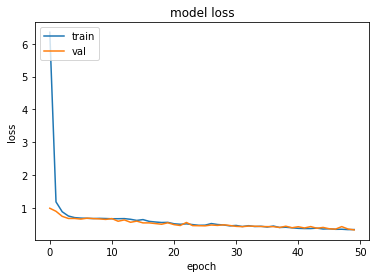

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()